In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import *
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from datetime import *
import datetime

In [ ]:
train_data = pd.read_csv('/content/gdrive/MyDrive/cs2/data/train.csv')
train_data

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0
...,...,...,...,...,...,...,...,...
1394,img_4637237.jpg,DA,52300.0,1307.5,2025-02-17,13153.00,1,4565.0
1395,img_4637000.jpg,BQ,41500.0,1037.5,2023-12-30,10453.00,1,3363.0
1396,img_4637503.jpg,AA,31400.0,785.0,2022-11-25,7928.00,1,5336.0
1397,img_4515101.jpg,A,33200.0,830.0,2022-10-10,8378.00,1,8734.0


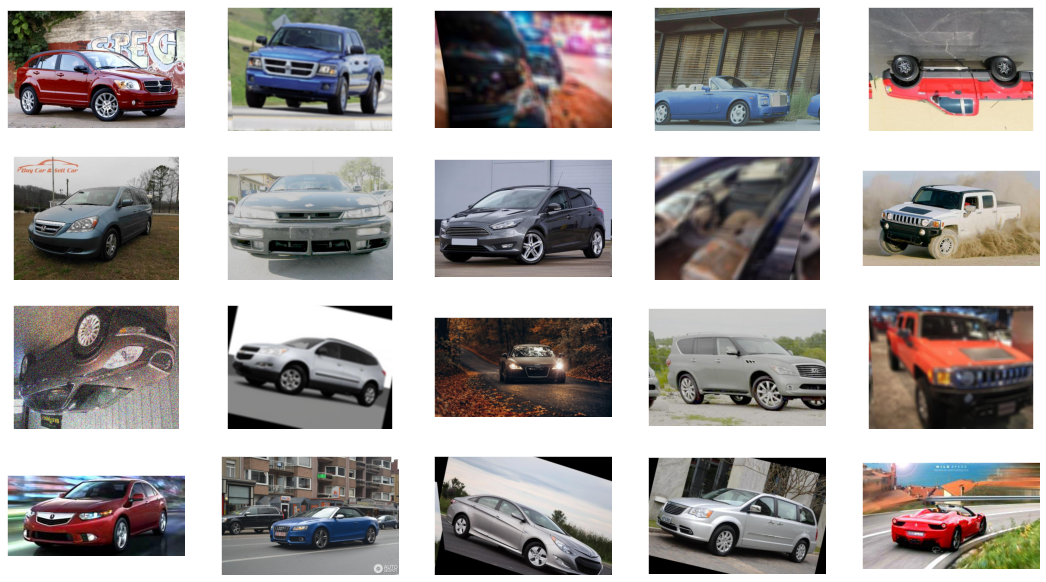

In [ ]:
#vehicle pics with undamaged condition 
path = '/content/gdrive/MyDrive/cs2/data/trainImages/'
for i,img in enumerate(train_data.loc[train_data['Condition']==0,'Image_path']):

    if i < 0:
       continue
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.subplot(4,5,i+1)
    img = plt.imread(path+str(img))

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i+=1
    if i == 20:
        break
plt.show()

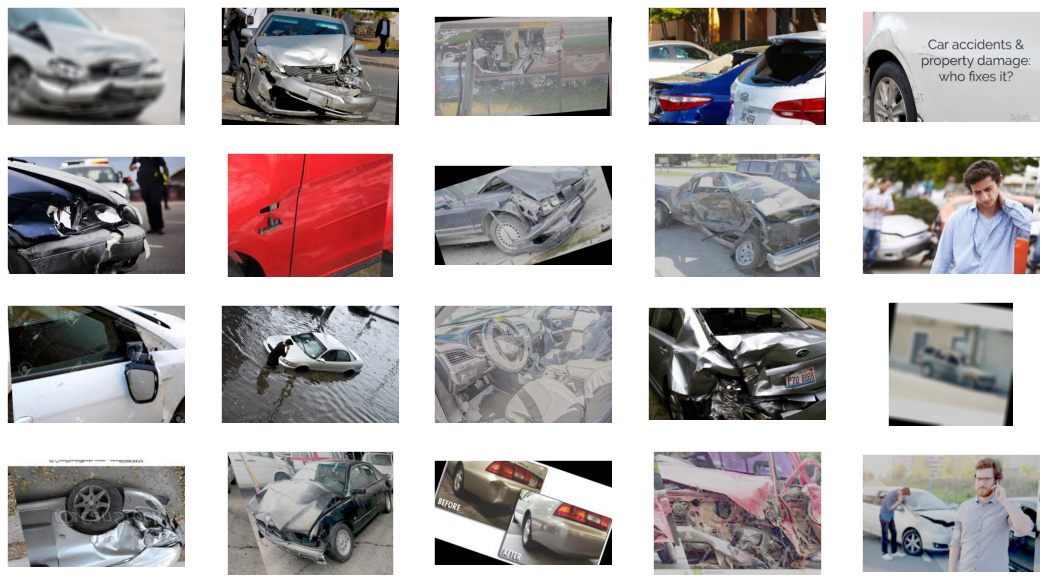

In [ ]:
#vehicle pics with damage condition
path = '/content/gdrive/MyDrive/cs2/data/trainImages/'
for i,img in enumerate(train_data.loc[train_data['Condition']==1,'Image_path']):

    if i < 0:
       continue
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.subplot(4,5,i+1)
    img = plt.imread(path+str(img))
    
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i+=1
    if i == 20:
        break
plt.show()

#1. EDA

In [ ]:
train_data[train_data['Amount'] > train_data['Max_coverage']]

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.0,1,8849.0
10,img_4516058.jpg,DA,23100.0,577.5,2023-06-08,5853.0,1,9634.0
39,img_4634526.jpg,BQ,36900.0,922.5,2023-10-04,9303.0,1,10598.0
51,img_4516363.jpg,O,35500.0,887.5,2028-11-11,8953.0,1,9093.0
85,img_4637399.jpg,RE,24300.0,607.5,2026-09-13,6153.0,1,8488.0
...,...,...,...,...,...,...,...,...
1324,img_7767995.jpg,AA,32500.0,812.5,2022-03-03,8203.0,1,59844.0
1351,img_4514501.jpg,O,23200.0,580.0,2028-04-17,5878.0,1,8636.0
1359,img_4635588.jpg,AA,24400.0,610.0,2027-08-31,6178.0,1,6448.0
1364,img_4635842.jpg,B,23800.0,595.0,2025-10-22,6028.0,1,6166.0


In [ ]:
train_data[(train_data['Amount'] > train_data['Max_coverage']) & train_data['Condition']==1]

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.0,1,8849.0
10,img_4516058.jpg,DA,23100.0,577.5,2023-06-08,5853.0,1,9634.0
39,img_4634526.jpg,BQ,36900.0,922.5,2023-10-04,9303.0,1,10598.0
51,img_4516363.jpg,O,35500.0,887.5,2028-11-11,8953.0,1,9093.0
85,img_4637399.jpg,RE,24300.0,607.5,2026-09-13,6153.0,1,8488.0
...,...,...,...,...,...,...,...,...
1324,img_7767995.jpg,AA,32500.0,812.5,2022-03-03,8203.0,1,59844.0
1351,img_4514501.jpg,O,23200.0,580.0,2028-04-17,5878.0,1,8636.0
1359,img_4635588.jpg,AA,24400.0,610.0,2027-08-31,6178.0,1,6448.0
1364,img_4635842.jpg,B,23800.0,595.0,2025-10-22,6028.0,1,6166.0


In [ ]:
train_data[(train_data['Amount'] > train_data['Max_coverage']) & train_data['Condition']==1].isnull().sum()

Image_path           0
Insurance_company    0
Cost_of_vehicle      0
Min_coverage         0
Expiry_date          0
Max_coverage         0
Condition            0
Amount               0
dtype: int64

<font color='green'>**OBSERVATIONS**</font>

<font color='green'>1. from the official given description/instruction it is not clear Amount column represents what, whether it is insurance premium amount or insurance claim amount or insurance sum assured amount, since this dataset have majority of damaged vehicle is seen from its distribution so we go with Amount as insurance claim amount. </font>

<font color='green'>2. since it is insurance claim amount, so claim cannot be greater than cost of vehicle and maximum insurance coverage amount, so we have to perform imputation on Amount column which are greater than cost_of_vehicle and Amount(insurance claim amount). </font>

<font color='green'>3. since dataset mention Max_coverage : Represents maximum coverage provided by insurance company, it is not clear whether this add-ons added or not on this Max_coverage. </font>

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_path         1399 non-null   object 
 1   Insurance_company  1399 non-null   object 
 2   Cost_of_vehicle    1310 non-null   float64
 3   Min_coverage       1310 non-null   float64
 4   Expiry_date        1399 non-null   object 
 5   Max_coverage       1310 non-null   float64
 6   Condition          1399 non-null   int64  
 7   Amount             1388 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 87.6+ KB


In [ ]:
train_data.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount
count,1310.000000,1310.000000,1310.000000,1399.000000,1388.000000
mean,37454.274809,936.356870,11242.925160,0.929235,4117.144092
std,8921.428143,223.035704,7163.735952,0.256523,3151.516223
min,11100.000000,277.500000,2853.000000,0.000000,-999.000000
25%,29800.000000,745.000000,7603.000000,1.000000,1641.750000
50%,37300.000000,932.500000,9678.000000,1.000000,4070.000000
75%,45175.000000,1129.375000,11703.000000,1.000000,6039.500000
max,53500.000000,1337.500000,46495.680000,1.000000,59844.000000


In [ ]:
train_data[train_data['Amount']<0]

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
641,img_7766741.jpg,O,NaN,NaN,2028-01-31,NaN,1,-999.0


**OBSERVATION**

1. train data, amount column value at min statitics, have negative value which is not possible, so we will be doing imputation based on its category to which insurance company this belongs here it is O.   ------- 1

##1.1 CHECK NULL

In [ ]:
train_data.isnull().sum()

Image_path            0
Insurance_company     0
Cost_of_vehicle      89
Min_coverage         89
Expiry_date           0
Max_coverage         89
Condition             0
Amount               11
dtype: int64

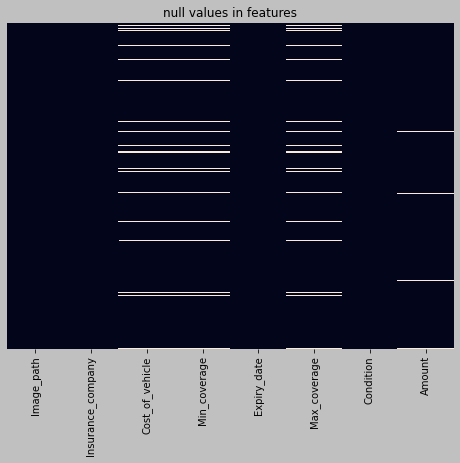

In [ ]:
def check_plot_null(data):
  fig = plt.figure(figsize=(8,6))
  fig.patch.set_facecolor('silver')
  sns.heatmap(data.isnull(), cbar=False, yticklabels=False)
  plt.title('null values in features')
  plt.show()

check_plot_null(train_data)

**OBSERVATION**

1. from above plot we see there is null value in cost of vehicle (89), minimum coverage (89), maximum coverage (89), amount (11).

2. we will not be droping the null data since we have very less data (1399 rows).

##1.2 VEHICLE CONDITION DISTRIBUTION

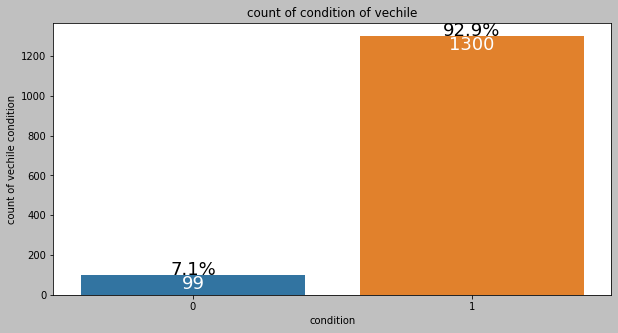

In [ ]:
def vech_cond_distribution(data, column):

  fig = plt.figure(figsize=(10,5))
  fig.patch.set_facecolor('silver')

  total = data.shape[0]

  ax = sns.countplot(x=column, data=data)
  for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()+1.4), ha='center', va='top', color='white', size=18)
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    ax.annotate(percentage, (p.get_x()+0.4, p.get_height()), ha='center', size=18)

  plt.xlabel('condition')
  plt.ylabel('count of vechile condition')
  plt.title('count of condition of vechile')
  plt.show()

vech_cond_distribution(train_data, 'Condition')

**OBSERVATION**

1. out of 1399 train data points, 1300 vechiles data points are damaged (1), which makes 92.9% of data, where as 99 vechiles data points are not damaged (0), which makes 7.1% of data.

##1.3 VEHICLE DISTRIBUION IN EACH INSURANCE COMPANY

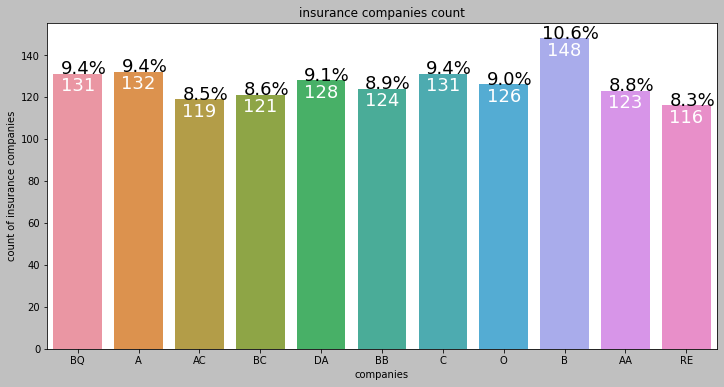

In [ ]:
def company_count(data, column):

  '''takes data : train data,
         column : insurance comapny column
        returns : number of data points in each insurance comapany with overall percentage data'''


  fig = plt.figure(figsize=(12,6))
  fig.patch.set_facecolor('silver')

  total = data.shape[0]

  ax = sns.countplot(x=column, data=data)
  for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()-1.4), ha='center', va='top', color='white', size=18)
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    ax.annotate(percentage, (p.get_x()+0.5, p.get_height()), ha='center', size=18)

  plt.xlabel('companies')
  plt.ylabel('count of insurance companies')
  plt.title('insurance companies count')
  plt.show()

company_count(train_data, 'Insurance_company')

**OBSERVATION**

1. almost every insurance company have nearly same percentage share, with highest being insurance company 'B' (10.6%), lowest share of insurance company 'RE' (8.3%).  

##1.4 CONDITION OF VEHICLE IN EACH INSURNACE COMPANY

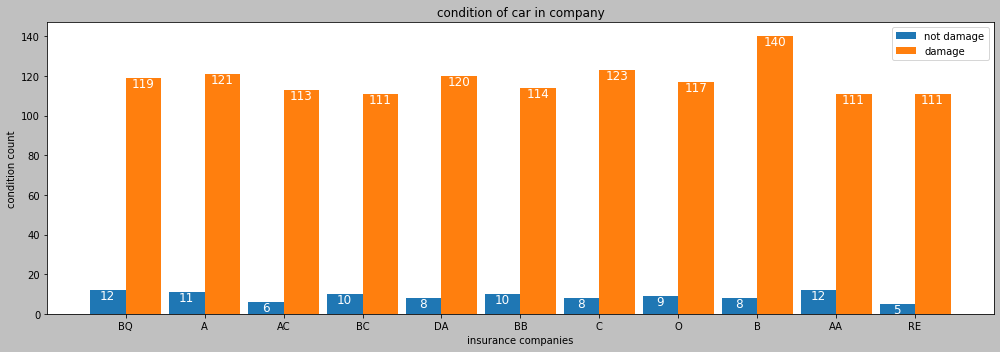

In [ ]:
def vech_condition_in_insurance_company(data, column, condition):

  '''takes data : train data,
         column : insurance comapny column,
      condition : damage(1) or not damage(0)
        returns : condition of vehicle (damage/not damge) in each insurance comapany'''

  labels = data[column].unique()

  zeros_lst = []
  ones_lst = []

  for i in labels:
    pt = data[data[column]==i].groupby(condition).agg({condition: ['count']})
    zeros_lst.append(pt.values.flatten()[0])
    ones_lst.append(pt.values.flatten()[1])


  x = np.arange(len(labels))  # the label locations
  width = 0.45                # the width of the bars

  fig, ax = plt.subplots(figsize=(14,5))
  fig.patch.set_facecolor('silver')


  rects1 = ax.bar(x - width/2, zeros_lst, width, label='not damage')
  rects2 = ax.bar(x + width/2, ones_lst, width, label='damage')
  for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+.22, p.get_height()+0.5), ha='center', va='top', color='white', size=12)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('condition count')
  ax.set_title('condition of car in company')
  ax.set_xlabel('insurance companies')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()

  plt.show()

vech_condition_in_insurance_company(train_data, 'Insurance_company', 'Condition')

**OBSERVATION**

1. from above data it is clear that every insurance company have very few data which is being not damage, but inrsurance comapny 'B' have highest (140), and 'BC', 'AA', 'RE' have lowest (111) each. 

2. this imbalance is being in line with statement, as we want to predict the price of claim to be paid based on damaged condition.

##1.5 IMPUTATAION

In [ ]:
def imputation_null_ins_cmpny(data, column, aggby, name):

  '''takes data : train data,
           column : insurance comapny column,
           aggby  : column name by which to aggregate,
             name : final reanamed column,
        returns : condition of vehicle (damage/not damge) in each insurance comapany'''

  labels = data[column].unique()
  df = pd.DataFrame()

  for i in labels:
    pt = data[data[column]==i].groupby(column).agg({aggby: ['median']})
    df = df.append({column : pt.index[0], name : round(pt.iloc[:,0].values[0],4)}, ignore_index=True)

  return df

In [ ]:
impute_data_cost_vech = imputation_null_ins_cmpny(train_data, 'Insurance_company', 'Cost_of_vehicle','mead_cost_vehicle')
impute_data_cost_vech

,Insurance_company,mead_cost_vehicle
0,BQ,40000.0
1,A,38600.0
2,AC,37300.0
3,BC,37500.0
4,DA,36700.0
5,BB,36700.0
6,C,35900.0
7,O,36900.0
8,B,36000.0
9,AA,36500.0


In [ ]:
impute_data_min_covrg = imputation_null_ins_cmpny(train_data, 'Insurance_company', 'Min_coverage','mead_min_coverage')
impute_data_min_covrg

,Insurance_company,mead_min_coverage
0,BQ,1000.0
1,A,965.0
2,AC,932.5
3,BC,937.5
4,DA,917.5
5,BB,917.5
6,C,897.5
7,O,922.5
8,B,900.0
9,AA,912.5


In [ ]:
impute_data_max_covrg = imputation_null_ins_cmpny(train_data, 'Insurance_company', 'Max_coverage','mead_max_coverage')
impute_data_max_covrg

,Insurance_company,mead_max_coverage
0,BQ,10403.0
1,A,9828.0
2,AC,9690.5
3,BC,9778.0
4,DA,9403.0
5,BB,9478.0
6,C,9165.5
7,O,9353.0
8,B,9428.0
9,AA,9428.0


In [ ]:
impute_data_mead_amt = imputation_null_ins_cmpny(train_data, 'Insurance_company', 'Amount','mead_amount')
impute_data_mead_amt

,Insurance_company,mead_amount
0,BQ,3757.0
1,A,4349.0
2,AC,4013.0
3,BC,4221.0
4,DA,4156.5
5,BB,3931.0
6,C,3389.0
7,O,3853.0
8,B,4481.0
9,AA,4048.0


In [ ]:
def impute_columns(data, column, col, condition, impute_data):

  '''takes data : train dataframe,
         column : insurance company column,
         col    : column which has null value,
      condition : condition od vehicle damage(0) or not damage(1),
    impute data : median value of column based on insurance company cat.
        return  : dataframe'''
  
  for i in impute_data[column].tolist():
    if col == 'Amount':
      ind = data.loc[(data[column]==i) & (data[condition]==1) & (data[col].isnull())].index
    else: 
      ind = data.loc[((data[column]==i) & (data[col].isnull()))].index

    for j in ind:
      data.loc[j, col] = impute_data.loc[(impute_data[column] == i)].values[0][-1]

  return data


In [ ]:
impute_columns(train_data, 'Insurance_company', 'Amount', 'Condition',impute_data_mead_amt)

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0
...,...,...,...,...,...,...,...,...
1394,img_4637237.jpg,DA,52300.0,1307.5,2025-02-17,13153.00,1,4565.0
1395,img_4637000.jpg,BQ,41500.0,1037.5,2023-12-30,10453.00,1,3363.0
1396,img_4637503.jpg,AA,31400.0,785.0,2022-11-25,7928.00,1,5336.0
1397,img_4515101.jpg,A,33200.0,830.0,2022-10-10,8378.00,1,8734.0


In [ ]:
train_data.loc[train_data['Condition']==0]['Amount'].value_counts()

0.0    99
Name: Amount, dtype: int64

In [ ]:
impute_columns(train_data, 'Insurance_company', 'Cost_of_vehicle', _, impute_data_cost_vech)

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0
...,...,...,...,...,...,...,...,...
1394,img_4637237.jpg,DA,52300.0,1307.5,2025-02-17,13153.00,1,4565.0
1395,img_4637000.jpg,BQ,41500.0,1037.5,2023-12-30,10453.00,1,3363.0
1396,img_4637503.jpg,AA,31400.0,785.0,2022-11-25,7928.00,1,5336.0
1397,img_4515101.jpg,A,33200.0,830.0,2022-10-10,8378.00,1,8734.0


In [ ]:
impute_columns(train_data, 'Insurance_company', 'Max_coverage', _, impute_data_max_covrg)

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0
...,...,...,...,...,...,...,...,...
1394,img_4637237.jpg,DA,52300.0,1307.5,2025-02-17,13153.00,1,4565.0
1395,img_4637000.jpg,BQ,41500.0,1037.5,2023-12-30,10453.00,1,3363.0
1396,img_4637503.jpg,AA,31400.0,785.0,2022-11-25,7928.00,1,5336.0
1397,img_4515101.jpg,A,33200.0,830.0,2022-10-10,8378.00,1,8734.0


In [ ]:
impute_columns(train_data, 'Insurance_company', 'Min_coverage', _, impute_data_min_covrg)

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0
...,...,...,...,...,...,...,...,...
1394,img_4637237.jpg,DA,52300.0,1307.5,2025-02-17,13153.00,1,4565.0
1395,img_4637000.jpg,BQ,41500.0,1037.5,2023-12-30,10453.00,1,3363.0
1396,img_4637503.jpg,AA,31400.0,785.0,2022-11-25,7928.00,1,5336.0
1397,img_4515101.jpg,A,33200.0,830.0,2022-10-10,8378.00,1,8734.0


In [ ]:
train_data.isnull().sum()

Image_path           0
Insurance_company    0
Cost_of_vehicle      0
Min_coverage         0
Expiry_date          0
Max_coverage         0
Condition            0
Amount               0
dtype: int64

##1.6 PDF AND CDF OF FEATURES

In [ ]:
def percentile_line(data, column):
  
  percentile25 = np.percentile(data[column].tolist(), 25)
  percentile50 = np.percentile(data[column].tolist(), 50)
  percentile75 = np.percentile(data[column].tolist(), 75)
  percentile99 = np.percentile(data[column].tolist(), 99)
  mean         = data[column].mean()

  return percentile25, percentile50, percentile75, percentile99, mean

In [ ]:
percentile25, percentile50, percentile75, percentile99, mean = percentile_line(train_data, 'Amount')

In [ ]:
def pdf_cdf(data, column):

  sns.set_style('dark')
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  sns.distplot(data[column])
  plt.text(20000, 0.00015,
           f'Skewness = {round(data[column].skew(),2)}\nKurtosis = {round(data[column].kurtosis(),2)}',
           fontdict=dict(fontsize=16))
  plt.vlines(percentile25, 0, .0005, color='c', ls='-.', lw=2, label='25th Percentile')
  plt.vlines(percentile50, 0, .0005, color='b', ls='-.', lw=2, label='50th Percentile')
  plt.vlines(percentile75, 0, .0005, color='g', ls='-.', lw=2, label='75th Percentile')
  plt.vlines(percentile99, 0, .0005, color='y', ls='-.', lw=2, label='99th Percentile')
  plt.vlines(mean        , 0, .0005, color='m', ls='-.', lw=2, label='Mean')
  plt.title(f'PDF of {column}')
  plt.legend(loc="upper right")

  plt.subplot(1,2,2)
  sns.distplot(data[column], kde_kws={'cumulative': True}, hist_kws={'cumulative': True})
  plt.vlines(percentile25, 0, 1, color='c', ls='--', lw=2, label='25th Percentile')
  plt.vlines(percentile50, 0, 1, color='b', ls='--', lw=2, label='50th Percentile')
  plt.vlines(percentile75, 0, 1, color='g', ls='--', lw=2, label='75th Percentile')
  plt.vlines(percentile99, 0, 1, color='y', ls='--', lw=2, label='99th Percentile')
  plt.vlines(mean        , 0, 1, color='m', ls='--', lw=2, label='Mean')
  plt.title(f'CDF of {column}')
  plt.legend(loc="lower right")


  plt.show()


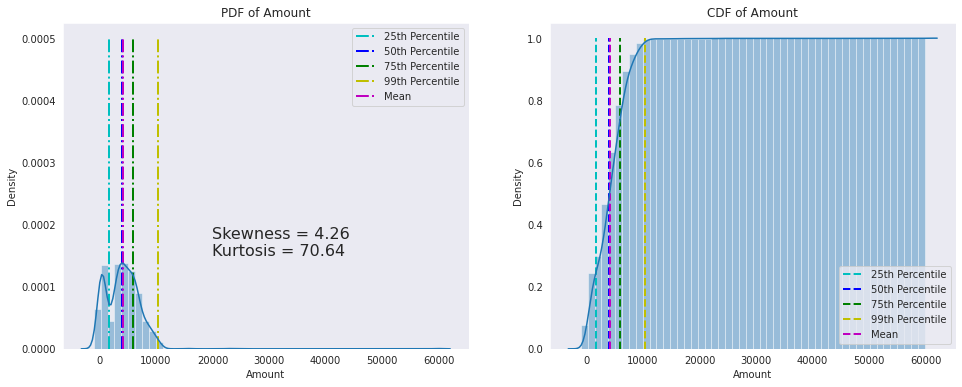

In [ ]:
pdf_cdf(train_data, 'Amount')

In [ ]:
for i in range(90, 101, 1):
    percentile = np.round(np.percentile(train_data['Amount'].tolist(), i), 4)
    print(f"{i} th Percentile \t: {percentile}")
print('\n', 35*'=', '\n')
for i in range(990, 1001, 1):
    i /= 10
    percentile = np.round(np.percentile(train_data['Amount'].tolist(), i), 4)
    print(f"{i} th Percentile \t: {percentile}")

90 th Percentile 	: 7659.0
91 th Percentile 	: 7861.18
92 th Percentile 	: 8060.72
93 th Percentile 	: 8310.22
94 th Percentile 	: 8563.44
95 th Percentile 	: 8740.6
96 th Percentile 	: 9074.2
97 th Percentile 	: 9372.34
98 th Percentile 	: 9725.64
99 th Percentile 	: 10302.68
100 th Percentile 	: 23000.0


99.0 th Percentile 	: 10302.68
99.1 th Percentile 	: 10374.038
99.2 th Percentile 	: 10458.824
99.3 th Percentile 	: 10484.782
99.4 th Percentile 	: 10504.18
99.5 th Percentile 	: 10524.15
99.6 th Percentile 	: 10545.12
99.7 th Percentile 	: 10589.464
99.8 th Percentile 	: 10705.02
99.9 th Percentile 	: 13795.454
100.0 th Percentile 	: 23000.0


**OBSERVATION**

1. The Distribution is right skewed and has a long tail on the right side, indicated by the high values for Skewness and Kurtosis.

2. The PDF has a long tail on the right which means there are few samples that have large value of Amount. These samples could affect the model training.

3. It can also be seen that there is a some gap between 99 percentile and 75 percentile value, which may also confirms the presence of few outliers in the data.

4. mean and 50th percentile almost lies on one another, effect of outlier if present is negligable.

5. Also peaks can be seen in the distribution at various values of Amount which indicate multimodal distribution.

6. Long tail on right is mainly due to single observation of 23000.

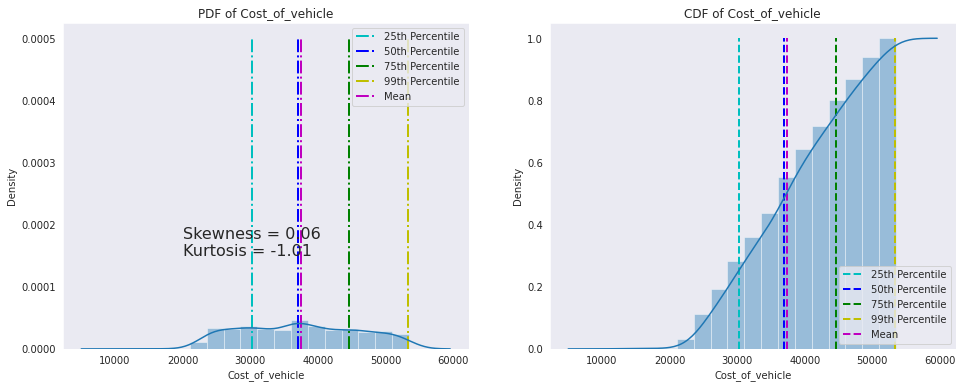

In [ ]:
percentile25, percentile50, percentile75, percentile99, mean = percentile_line(train_data, 'Cost_of_vehicle')
pdf_cdf(train_data, 'Cost_of_vehicle')

In [ ]:
for i in range(0, 11, 1):
    percentile = np.round(np.percentile(train_data['Cost_of_vehicle'].tolist(), i), 4)
    print(f"{i} th Percentile \t: {percentile}")

0 th Percentile 	: 11100.0
1 th Percentile 	: 22900.0
2 th Percentile 	: 23296.0
3 th Percentile 	: 23500.0
4 th Percentile 	: 23900.0
5 th Percentile 	: 24200.0
6 th Percentile 	: 24488.0
7 th Percentile 	: 24686.0
8 th Percentile 	: 24900.0
9 th Percentile 	: 25200.0
10 th Percentile 	: 25500.0


**OBSERVATION**

1. The Distribution is left skewed and has a long tail on the left side, indicated by the low values for Skewness and Kurtosis.

2. kurtosis negative value show flatter curve. 

2. The PDF has a long tail on the left which means there are few samples that have large value of Amount. These samples could affect the model training.

3. It can also be seen that there is a some gap between 0 percentile and 1 percentile value, which may also confirms the presence of few outliers in the data.

4. mean and 50th percentile almost lies on one another, effect of outlier if present is negligable.

5. Also peaks can be seen in the distribution at single values of Cost_of_vehicle which indicate single-modal distribution.

6. Long tail on left is mainly due to single observation of 11100.

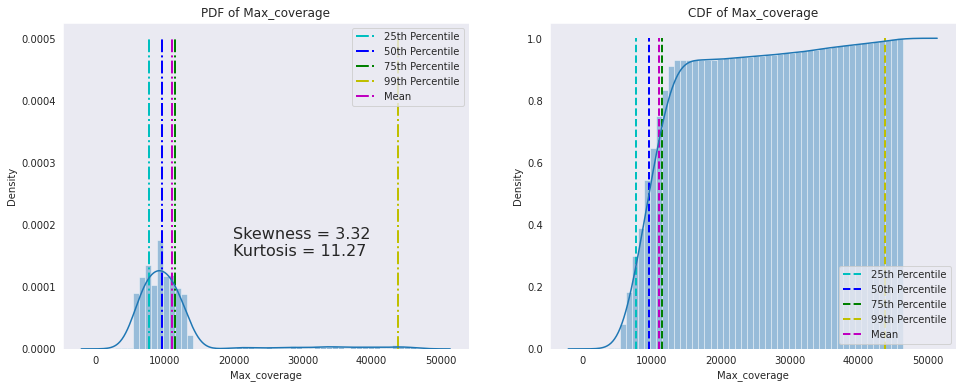

In [ ]:
percentile25, percentile50, percentile75, percentile99, mean = percentile_line(train_data, 'Max_coverage')
pdf_cdf(train_data, 'Max_coverage')

In [ ]:
for i in range(70, 99, 5):
    percentile = np.round(np.percentile(train_data['Max_coverage'].tolist(), i), 4)
    print(f"{i} th Percentile \t: {percentile}")
#print('\n', 35*'=', '\n')
#for i in range(990, 1001, 1):
#    i /= 10
#    percentile = np.round(np.percentile(train_data['Max_coverage'].tolist(), i), 4)
#    print(f"{i} th Percentile \t: {percentile}")

70 th Percentile 	: 11203.0
75 th Percentile 	: 11603.0
80 th Percentile 	: 12078.0
85 th Percentile 	: 12603.0
90 th Percentile 	: 13178.0
95 th Percentile 	: 28538.88


In [ ]:
for i in range(90, 101, 1):
    percentile = np.round(np.percentile(train_data['Max_coverage'].tolist(), i), 4)
    print(f"{i} th Percentile \t: {percentile}")
print('\n', 35*'=', '\n')
for i in range(990, 1001, 1):
    i /= 10
    percentile = np.round(np.percentile(train_data['Max_coverage'].tolist(), i), 4)
    print(f"{i} th Percentile \t: {percentile}")

90 th Percentile 	: 13178.0
91 th Percentile 	: 13303.0
92 th Percentile 	: 13382.0
93 th Percentile 	: 13453.0
94 th Percentile 	: 23238.84
95 th Percentile 	: 28538.88
96 th Percentile 	: 33198.6
97 th Percentile 	: 35646.78
98 th Percentile 	: 39535.68
99 th Percentile 	: 43798.68
100 th Percentile 	: 46495.68


99.0 th Percentile 	: 43798.68
99.1 th Percentile 	: 43798.68
99.2 th Percentile 	: 44153.64
99.3 th Percentile 	: 44407.68
99.4 th Percentile 	: 44460.924
99.5 th Percentile 	: 44585.16
99.6 th Percentile 	: 45000.672
99.7 th Percentile 	: 45314.046
99.8 th Percentile 	: 45872.412
99.9 th Percentile 	: 46495.68
100.0 th Percentile 	: 46495.68


**OBSERVATION**

1. The Distribution is right skewed and has a long tail on the right side, indicated by the high values for Skewness and Kurtosis.

2. The PDF has a long tail on the right which means there are few samples that have large value of Amount. These samples could affect the model training.

3. It can also be seen that there is a some gap between 99 percentile and 75 percentile value, which may also confirms the presence of few outliers in the data.

4. mean and 50th have slight distance from one another, effect of outlier is there.

5. Also peaks can be seen in the distribution at single values of Max_coverage which indicate singlemodal distribution.

6. Long tail on right is mainly due to 75-95th percentile which approx 2.5 times.

In [ ]:
def pdf_cdf(data, column):

  sns.set_style('dark')
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  sns.distplot(data[column])
  plt.text(100, 0.003,
           f'Skewness = {round(data[column].skew(),2)}\nKurtosis = {round(data[column].kurtosis(),2)}',
           fontdict=dict(fontsize=16))
  plt.vlines(percentile25, 0, .005, color='c', ls='-.', lw=2, label='25th Percentile')
  plt.vlines(percentile50, 0, .005, color='b', ls='-.', lw=2, label='50th Percentile')
  plt.vlines(percentile75, 0, .005, color='g', ls='-.', lw=2, label='75th Percentile')
  plt.vlines(percentile99, 0, .005, color='y', ls='-.', lw=2, label='99th Percentile')
  plt.vlines(mean        , 0, .005, color='m', ls='-.', lw=2, label='Mean')
  plt.title(f'PDF of {column}')
  plt.legend(loc="upper right")

  plt.subplot(1,2,2)
  sns.distplot(data[column], kde_kws={'cumulative': True}, hist_kws={'cumulative': True})
  plt.vlines(percentile25, 0, 1, color='c', ls='--', lw=2, label='25th Percentile')
  plt.vlines(percentile50, 0, 1, color='b', ls='--', lw=2, label='50th Percentile')
  plt.vlines(percentile75, 0, 1, color='g', ls='--', lw=2, label='75th Percentile')
  plt.vlines(percentile99, 0, 1, color='y', ls='--', lw=2, label='99th Percentile')
  plt.vlines(mean        , 0, 1, color='m', ls='--', lw=2, label='Mean')
  plt.title(f'CDF of {column}')
  plt.legend(loc="lower right")


  plt.show()


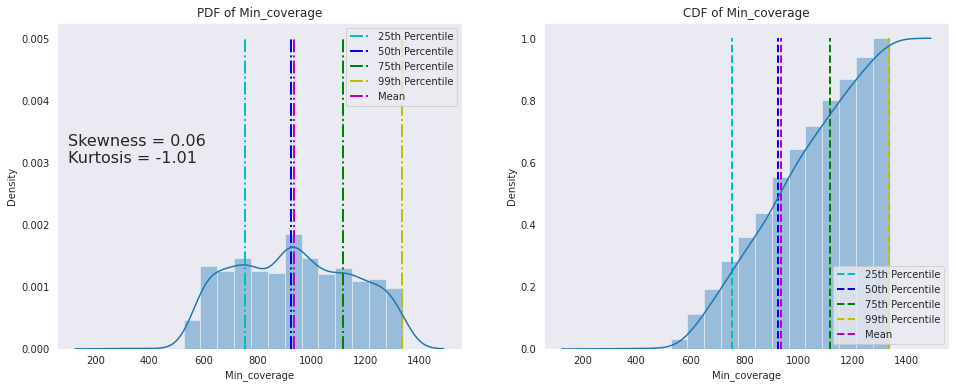

In [ ]:
percentile25, percentile50, percentile75, percentile99, mean = percentile_line(train_data, 'Min_coverage')
pdf_cdf(train_data, 'Min_coverage')

In [ ]:
for i in range(0, 11, 1):
    percentile = np.round(np.percentile(train_data['Min_coverage'].tolist(), i), 4)
    print(f"{i} th Percentile \t: {percentile}")

0 th Percentile 	: 277.5
1 th Percentile 	: 572.5
2 th Percentile 	: 582.4
3 th Percentile 	: 587.5
4 th Percentile 	: 597.5
5 th Percentile 	: 605.0
6 th Percentile 	: 612.2
7 th Percentile 	: 617.15
8 th Percentile 	: 622.5
9 th Percentile 	: 630.0
10 th Percentile 	: 637.5


**OBSERVATION**

1. The Distribution is slight left skewed and has a long tail on the left side, indicated by the low values for Skewness and Kurtosis.

2. kurtosis negative value show somewhat flatter curve. 

2. The PDF has a long tail on the left which means there are few samples that have large value of Amount. These samples could affect the model training.

3. It can also be seen that there is a some gap between 0 percentile and 1 percentile value, which may also confirms the presence of few outliers in the data.

4. mean and 50th percentile almost lies on one another, effect of outlier if present is negligable.

5. Also peaks can be seen in the distribution at single values of Min_coverage which indicate single-modal distribution.

6. Long tail on left is mainly due to single observation of 0th percentile 277.5.

##1.7 CHECKING DISTRIBUTION OF CONTINUOUS VRIABLE

In [ ]:
def digo_plot(data, variable):
  fig = plt.figure(figsize=(15,6))
  fig.patch.set_facecolor('silver')
  sns.set_style("darkgrid")
  plt.subplot(1,2,1)
  
  sns.distplot(data[variable])

  plt.subplot(1,2,2)
  stats.probplot(data[variable], dist='norm', plot = plt)
  plt.title('QQ-plot')
  plt.show()


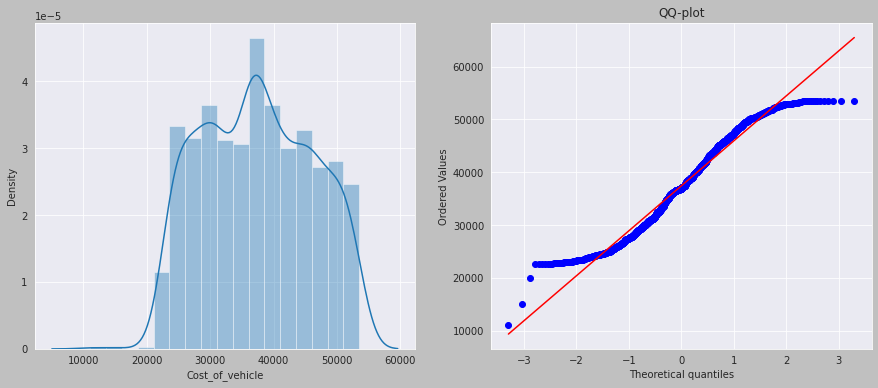

In [ ]:
digo_plot(train_data, 'Cost_of_vehicle')

**OBSERVATION**

1. we have used normal distribution as base, distribution of cost_of_vehicle follows roughly normal distribution.

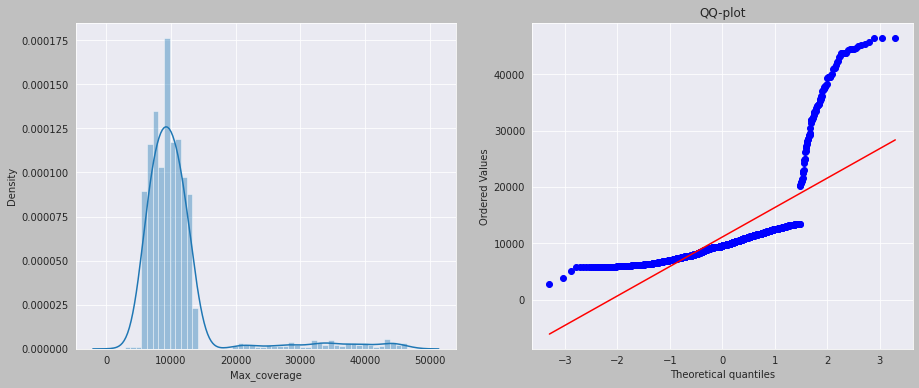

In [ ]:
digo_plot(train_data, 'Max_coverage')

**OBSERVATION**

1. we have used normal distribution as base, distribution of Max_coverage do not follows roughly normal distribution.

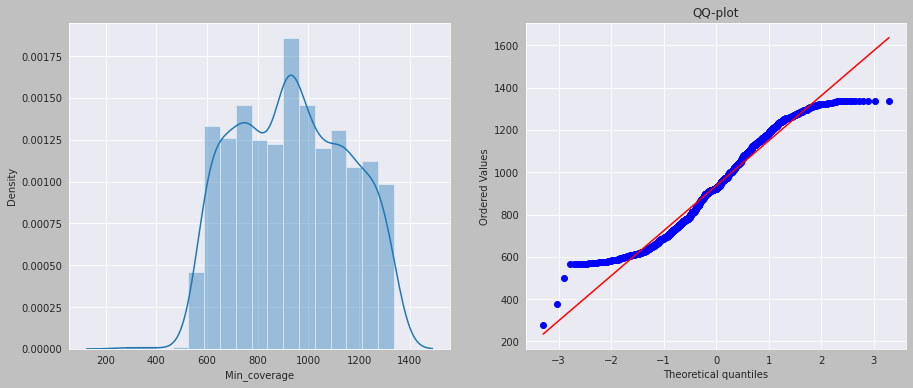

In [ ]:
digo_plot(train_data, 'Min_coverage')

**OBSERVATION**

1. we have used normal distribution as base, distribution of Min_coverage follows roughly normal distribution.

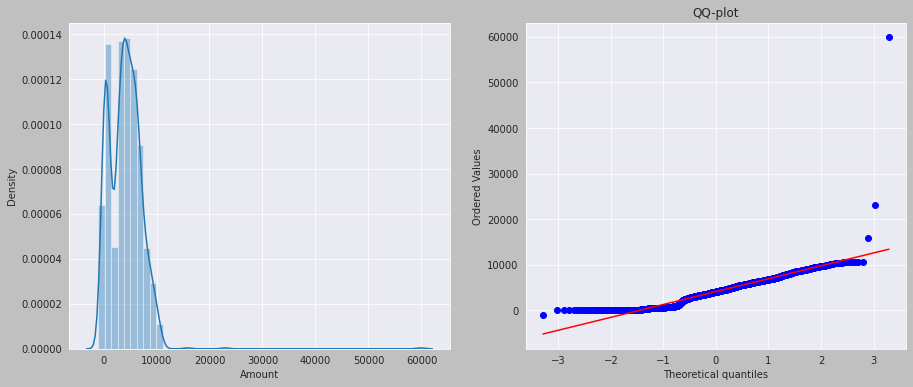

In [ ]:
digo_plot(train_data, 'Amount')

**OBSERVATION**

1. we have used normal distribution as base, distribution of Amount follows roughly normal distribution, with some outliers.

##1.8 CORRELATION AMONG FEATURES

In [ ]:
  def correlation_numerical(data):
    fig = plt.figure(figsize=(10,5))
    fig.patch.set_facecolor('silver')
    corr_matrix = data.corr(method='pearson')
    sns.heatmap(corr_matrix, annot=True)
    plt.show()

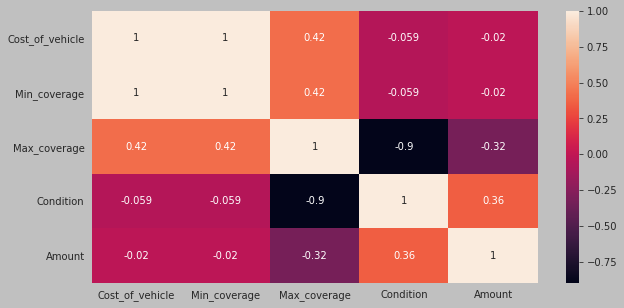

In [ ]:
correlation_numerical(train_data)

**OBSERVATION**

1. Min_coverage and Cost_of_vehicle have perfect coreelation of 1,so use either cost of vechile or min coverage.

##1.9 BOX PLOT 

In [ ]:
  def box_plot(data, col1, col2):
    fig = plt.figure(figsize=(14,6))
    fig.patch.set_facecolor('silver')
    sns.boxplot(x=col1, y=col2, data=data)
    plt.hlines(np.mean(data[col2]), -1, 12, color='r', ls='-.', lw=2, label=f'mean of {col2}')
    plt.hlines(np.median(data[col2]), -1, 12, color='g', ls='-.', lw=2, label=f'median of {col2}')
    plt.hlines(np.percentile(data[col2],25), -1, 12, color='y', ls='-.', lw=2, label=f'25 percentile of {col2}')
    plt.hlines(np.percentile(data[col2],75), -1, 12, color='m', ls='-.', lw=2, label=f'75 percentile of {col2}')
    plt.title(f'Box plot of insurance company vs {col2}')
    plt.legend()
    plt.show()

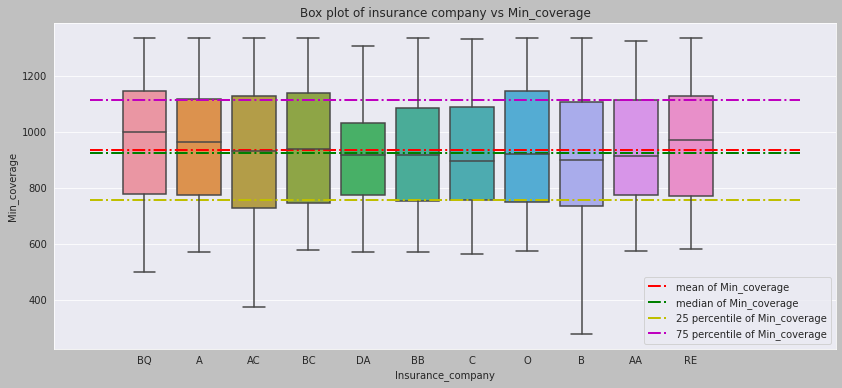

In [ ]:
box_plot(train_data, 'Insurance_company', 'Min_coverage')   ##cbgym

In [ ]:
print('conclusion from above plot of Insurance_company vs Min_coverage :')
print('-'*65)
print(f'25 percentile  : {np.percentile(train_data["Min_coverage"].values, 25)}')
print(f'median         : {np.median(train_data["Min_coverage"].values)}')
print(f'75 percentile  : {np.percentile(train_data["Min_coverage"].values, 75)}')
print(' ')
print(f'iqr  : {np.percentile(train_data["Min_coverage"].values, 75) - np.percentile(train_data["Min_coverage"].values, 25)}')
print(' ')
print(f'acc. theory  outliers : {(np.percentile(train_data["Min_coverage"].values, 75) - np.percentile(train_data["Min_coverage"].values, 25))*1.5}')
print(' ')
print(f'range    : {max(train_data["Min_coverage"].values) - min(train_data["Min_coverage"].values)}')

conclusion from above plot of Insurance_company vs Min_coverage :
-----------------------------------------------------------------
25 percentile  : 755.0
median         : 925.0
75 percentile  : 1115.0
 
iqr  : 360.0
 
acc. theory  outliers : 540.0
 
range    : 1060.0


**OBSERVATION**

1. we see that median of Min_coverage almost coinsides with median of each insurance company. 

2. we see that 25 percentile of Min_coverage almost coinsides with 25 percentile of each insurance company. 

3. we see that 75 percentile of Min_coverage almost coinsides with 75 percentile of each insurance company. 

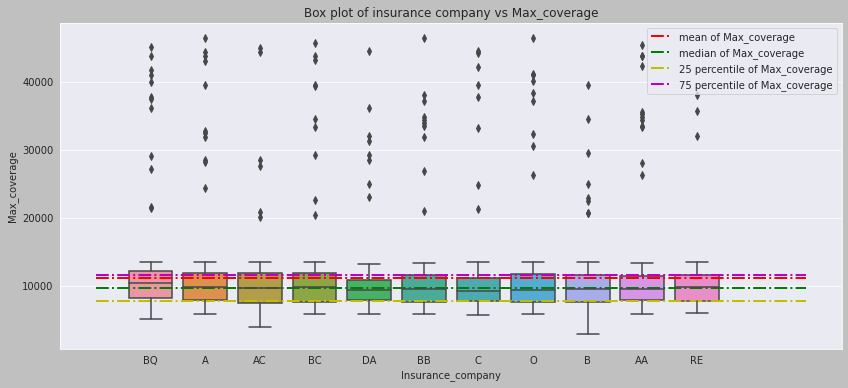

In [ ]:
box_plot(train_data, 'Insurance_company', 'Max_coverage') 

In [ ]:
print('conclusion from above plot of Insurance_company vs Max_coverage :')
print('-'*65)
print(f'25 percentile  : {np.percentile(train_data["Max_coverage"].values, 25)}')
print(f'median         : {np.median(train_data["Max_coverage"].values)}')
print(f'75 percentile  : {np.percentile(train_data["Max_coverage"].values, 75)}')
print(' ')
print(f'iqr  : {np.percentile(train_data["Max_coverage"].values, 75) - np.percentile(train_data["Max_coverage"].values, 25)}')
print(' ')
print(f'acc. theory  outliers : {(np.percentile(train_data["Max_coverage"].values, 75) - np.percentile(train_data["Max_coverage"].values, 25))*1.5}')
print(' ')
print(f'range    : {max(train_data["Max_coverage"].values) - min(train_data["Max_coverage"].values)}')

conclusion from above plot of Insurance_company vs Max_coverage :
-----------------------------------------------------------------
25 percentile  : 7728.0
median         : 9603.0
75 percentile  : 11603.0
 
iqr  : 3875.0
 
acc. theory  outliers : 5812.5
 
range    : 43642.68


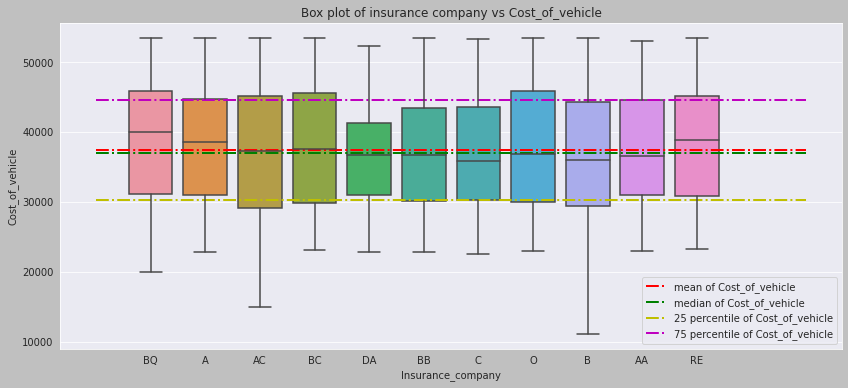

In [ ]:
box_plot(train_data, 'Insurance_company', 'Cost_of_vehicle') 

In [ ]:
print('conclusion from above plot of Insurance_company vs Cost_of_vehicle :')
print('-'*68)
print(f'25 percentile  : {np.percentile(train_data["Cost_of_vehicle"].values, 25)}')
print(f'median         : {np.median(train_data["Cost_of_vehicle"].values)}')
print(f'75 percentile  : {np.percentile(train_data["Cost_of_vehicle"].values, 75)}')
print(' ')
print(f'iqr  : {np.percentile(train_data["Cost_of_vehicle"].values, 75) - np.percentile(train_data["Cost_of_vehicle"].values, 25)}')
print(' ')
print(f'acc. theory  outliers : {(np.percentile(train_data["Cost_of_vehicle"].values, 75) - np.percentile(train_data["Cost_of_vehicle"].values, 25))*1.5}')
print(' ')
print(f'range    : {max(train_data["Cost_of_vehicle"].values) - min(train_data["Cost_of_vehicle"].values)}')

conclusion from above plot of Insurance_company vs Cost_of_vehicle :
--------------------------------------------------------------------
25 percentile  : 30200.0
median         : 37000.0
75 percentile  : 44600.0
 
iqr  : 14400.0
 
acc. theory  outliers : 21600.0
 
range    : 42400.0


**OBSERVATION**

1. we see that median of Cost_of_vehicle almost coinsides with median of each insurance company. 

2. we see that 25 percentile of Cost_of_vehicle almost coinsides with 25 percentile of each insurance company. 

3. we see that 75 percentile of Cost_of_vehicle almost coinsides with 75 percentile of each insurance company. 

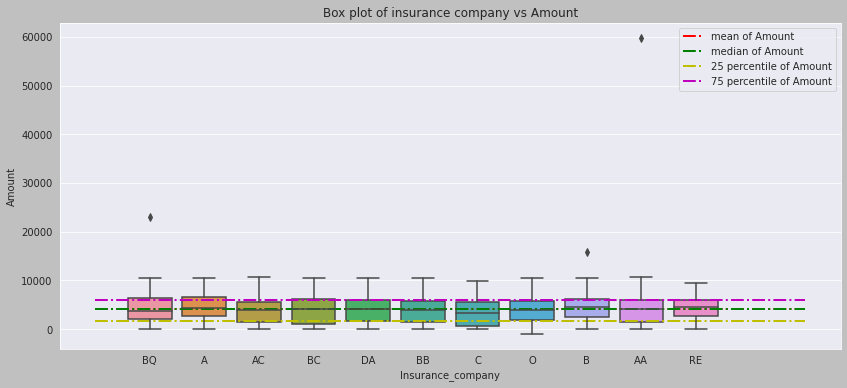

In [ ]:
box_plot(train_data, 'Insurance_company', 'Amount') 

In [ ]:
print('conclusion from above plot of Insurance_company vs Amount :')
print('-'*60)
print(f'25 percentile  : {np.percentile(train_data["Amount"].values, 25)}')
print(f'median         : {np.median(train_data["Amount"].values)}')
print(f'75 percentile  : {np.percentile(train_data["Amount"].values, 75)}')
print(' ')
print(f'iqr  : {np.percentile(train_data["Amount"].values, 75) - np.percentile(train_data["Amount"].values, 25)}')
print(' ')
print(f'acc. theory  outliers : {(np.percentile(train_data["Amount"].values, 75) - np.percentile(train_data["Amount"].values, 25))*1.5}')
print(' ')
print(f'range    : {max(train_data["Amount"].values) - min(train_data["Amount"].values)}')

conclusion from above plot of Insurance_company vs Amount :
------------------------------------------------------------
25 percentile  : 1693.5
median         : 4071.0
75 percentile  : 6016.0
 
iqr  : 4322.5
 
acc. theory  outliers : 6483.75
 
range    : 60843.0


#1.10 OUTLIER TREATMENT

In [ ]:
max(train_data['Amount'])

59844.0

In [ ]:
train_data[train_data['Amount']>58000]  ## replace amt with aa median ammount 

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
1324,img_7767995.jpg,AA,32500.0,812.5,2022-03-03,8203.0,1,59844.0


In [ ]:
train_data.loc[1324,'Amount'] = 4048.0   ## replace amt with aa median ammount 

In [ ]:
train_data[train_data['Amount']>58000]  ## no such row

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount


In [ ]:
train_data[train_data['Amount']<0]  ## replace amt with O median ammount 

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
641,img_7766741.jpg,O,36900.0,922.5,2028-01-31,9353.0,1,-999.0


In [ ]:
train_data.loc[641,"Amount"] = 3853.0

In [ ]:
train_data[train_data['Amount']<0]    ## no such row

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount


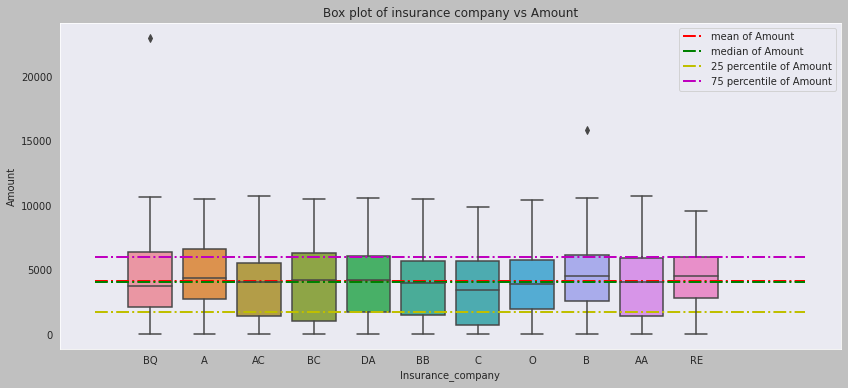

In [ ]:
box_plot(train_data, 'Insurance_company', 'Amount') 

In [ ]:
print('conclusion from above plot of Insurance_company vs Amount :')
print('-'*60)
print(f'25 percentile  : {np.percentile(train_data["Amount"].values, 25)}')
print(f'median         : {np.median(train_data["Amount"].values)}')
print(f'75 percentile  : {np.percentile(train_data["Amount"].values, 75)}')
print(' ')
print(f'iqr  : {np.percentile(train_data["Amount"].values, 75) - np.percentile(train_data["Amount"].values, 25)}')
print(' ')
print(f'acc. theory  outliers : {(np.percentile(train_data["Amount"].values, 75) - np.percentile(train_data["Amount"].values, 25))*1.5}')
print(' ')
print(f'range    : {max(train_data["Amount"].values) - min(train_data["Amount"].values)}')

conclusion from above plot of Insurance_company vs Amount :
------------------------------------------------------------
25 percentile  : 1711.0
median         : 4069.0
75 percentile  : 6007.5
 
iqr  : 4296.5
 
acc. theory  outliers : 6444.75
 
range    : 23000.0


**OBSERVATION**

1. we see that median of Amount almost coinsides with median of each insurance company. 

2. we see that 25 percentile of Amount almost coinsides with 25 percentile of each insurance company. 

3. we see that 75 percentile of Amount almost coinsides with 75 percentile of each insurance company. 

In [ ]:
train_data[(train_data['Insurance_company']=='BQ') & (train_data['Amount']>20000)]

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
786,img_7764865.jpg,BQ,48200.0,1205.0,2023-01-15,12128.0,1,23000.0


In [ ]:
train_data[(train_data['Insurance_company']=='B') & (train_data['Amount']>10000)]

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
575,img_7766535.jpg,B,33500.0,837.5,2022-01-03,8453.0,1,10554.0
955,img_4635923.jpg,B,28400.0,710.0,2024-10-26,7178.0,1,15836.0


**OBSERVATION**

1. from above two cell we se that claim Amount is greater than Max_coverage, as of data description it is not mention whether this Max_coverage includes add-ons or not, and whether this Max_coverage before add-ons or after add-ons, for sake of generalness we assume it is without add-ons, so claim excedding max.coverage may be because of extra addons so not treating as outliers but other scenario is possible too. 

##1.11 PAIR PLOT

In [ ]:
  def pair_plt(data,column):
    fig = plt.figure(figsize=(15,15))
    fig.patch.set_facecolor('silver')
    sns.set_style('dark')
    sns.pairplot(data=data, hue=column, kind='scatter',diag_kind="kde")
    plt.show()

<Figure size 1080x1080 with 0 Axes>

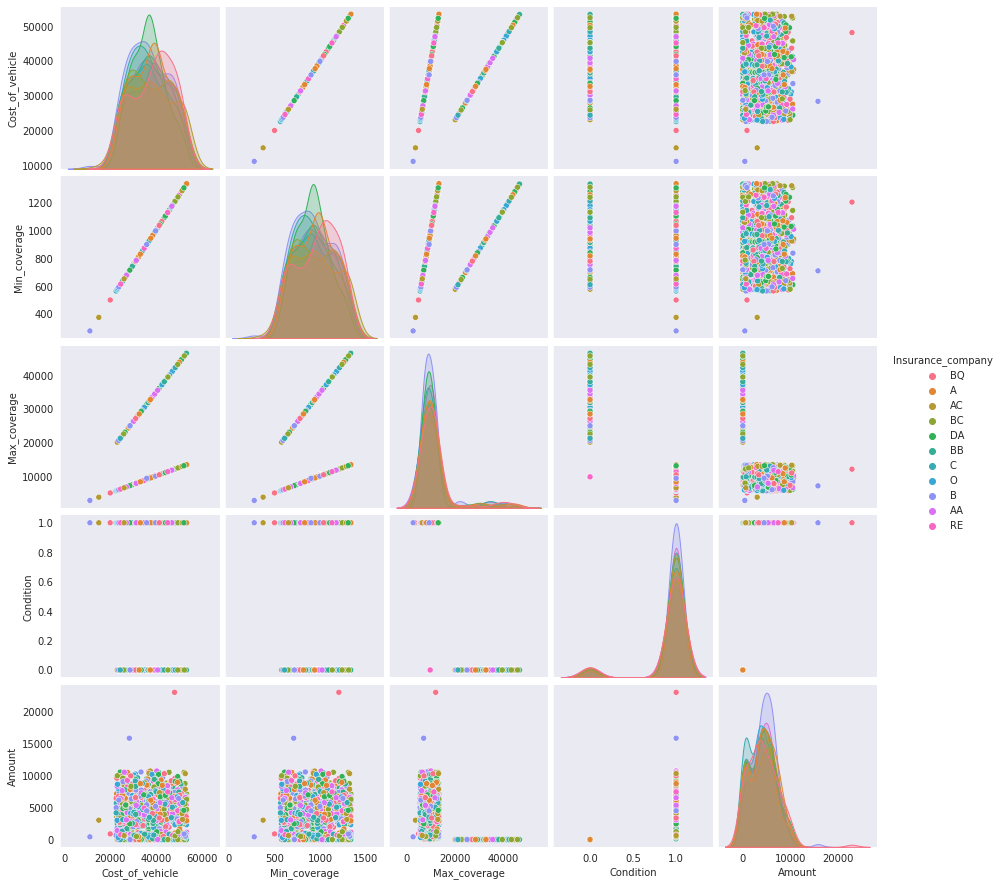

In [ ]:
pair_plt(train_data, 'Insurance_company')

In [ ]:
def bi_plot(data, col, col0, col1, col2):
  fig, axes = plt.subplots(1, 2, figsize=(15, 6))
  fig.patch.set_facecolor('silver')

  plt.subplot(1, 2, 1) 
  sns.scatterplot(x=col1, y=col0, data=data, hue=col)
  plt.xlabel(f'{col1}')
  plt.ylabel(f'{col0}')
  plt.title(f'Train data {col0} vs {col1}')

  plt.subplot(1, 2, 2) 
  sns.scatterplot(x=col2, y=col0, data=data, hue=col)
  plt.xlabel(f'{col2}')
  plt.ylabel(f'{col0}')
  plt.title(f'Train data {col0} vs {col2}')
  plt.show()

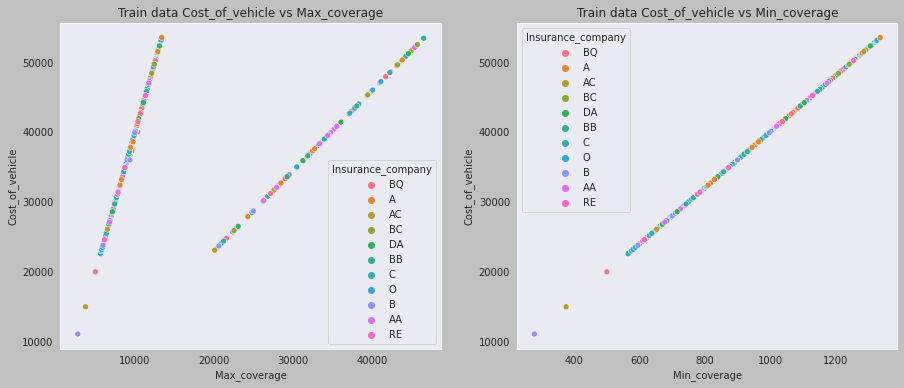

In [ ]:
bi_plot(train_data, 'Insurance_company', 'Cost_of_vehicle', 'Max_coverage', 'Min_coverage')

In [ ]:
train_data.loc[train_data['Max_coverage'] > 20000]['Condition'].value_counts()

0    97
Name: Condition, dtype: int64

**OBSERVATION**

1. condition on which Max_coverage is decided is based on 2 seperable categories, i.e greater than 20000 (which have almost all insurance company), do not have any damages, this helps to design a feature in feature engineering section (if Max_coverage greater than >20000 or not) i.e describe category of insurance.

#2 Feature engineering

##2.1 CHECKING TRAIN DATASET

In [ ]:
import datetime

def feature_engg(data, col1, col2, col3, col4, col5):
  
  '''takes data : train/test dataframe,
     col1       : expiry_date,
     col2       : cost-of-vehicle,
     col3       : insurance company,
     col4       : max coverage
     col5       : min coverage
     returns    : newly computed feature in dataframe'''


  today = datetime.datetime(2021,9,12,0,0,0)
  luxury_seg = np.percentile(data[col2], 75)
  medium_seg = np.percentile(data[col2], 25)
  cmp_cnt = data[col3].value_counts()


  data[col1]           = data[col1].apply(pd.to_datetime)
  data['year']         = data[col1].apply(lambda x : x.year)
  data['month']        = data[col1].apply(lambda x: x.month)
  data['month_day']    = data[col1].apply(lambda x: x.day)
  data['yr_day']       = data[col1].apply(lambda x: x.dayofyear)
  data['week_day']     = data[col1].apply(lambda x: x.weekday())
  data['week_no']      = data[col1].apply(lambda x: x.week)
  data['lux_seg']      = data[col2].apply(lambda x: 1 if x>luxury_seg else 0)
  data['med_seg']      = data[col2].apply(lambda x: 1 if (x<luxury_seg and x>medium_seg) else 0)
  data['budget_seg']   = data[col2].apply(lambda x: 1 if (x<medium_seg) else 0)
  data['age_of_insur'] = data[col1].apply(lambda x: round(abs((today-x).days)/365,2))

  md_age = np.median(data['age_of_insur'])

  data['cmpny_count']       = data[col3].apply(lambda x: cmp_cnt[x])
  data['range_of_coverage'] = data[col4]-data[col5]
  data['insuran_pd']        = data['age_of_insur'].apply(lambda x: 1 if x > md_age else 0)
  data['low_expire']        = data['age_of_insur'].apply(lambda x: 1 if x < 2 else 0)
  data['med_expire']        = data['age_of_insur'].apply(lambda x: 1 if (x > 2 and x<5) else 0)
  data['hig_expire']        = data['age_of_insur'].apply(lambda x: 1 if  x>5 else 0)
  data['cost_grt_20k']      = data[col4].apply(lambda x : 1 if x > 20000 else 0)

  return data

In [ ]:
train_data_f = feature_engg(train_data, 'Expiry_date', 'Cost_of_vehicle', 'Insurance_company', 'Max_coverage', 'Min_coverage')
train_data_f

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount,year,month,month_day,yr_day,week_day,week_no,lux_seg,med_seg,budget_seg,age_of_insur,cmpny_count,range_of_coverage,insuran_pd,low_expire,med_expire,hig_expire,cost_grt_20k
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0,2026,12,3,337,3,49,0,1,0,5.23,131,35105.18,1,0,0,1,1
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0,2025,7,10,191,3,28,1,0,0,3.83,131,11485.50,1,0,1,0,0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0,2022,8,11,223,3,32,1,0,0,0.91,132,41865.18,0,1,0,0,1
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0,2022,8,2,214,1,31,0,1,0,0.89,132,7615.50,0,1,0,0,0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0,2026,5,1,121,4,18,0,0,1,4.64,119,6288.00,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,img_4637237.jpg,DA,52300.0,1307.5,2025-02-17,13153.00,1,4565.0,2025,2,17,48,0,8,1,0,0,3.44,128,11845.50,0,0,1,0,0
1395,img_4637000.jpg,BQ,41500.0,1037.5,2023-12-30,10453.00,1,3363.0,2023,12,30,364,5,52,0,1,0,2.30,131,9415.50,0,0,1,0,0
1396,img_4637503.jpg,AA,31400.0,785.0,2022-11-25,7928.00,1,5336.0,2022,11,25,329,4,47,0,1,0,1.20,123,7143.00,0,1,0,0,0
1397,img_4515101.jpg,A,33200.0,830.0,2022-10-10,8378.00,1,8734.0,2022,10,10,283,0,41,0,1,0,1.08,132,7548.00,0,1,0,0,0


In [ ]:
train_data_f.insert(len(train_data_f.columns)-1, 'Condition', train_data_f.pop('Condition'))
train_data_f.insert(len(train_data_f.columns)-1, 'Amount', train_data_f.pop('Amount'))

In [ ]:
train_data_f.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,year,month,month_day,yr_day,week_day,week_no,lux_seg,med_seg,budget_seg,age_of_insur,cmpny_count,range_of_coverage,insuran_pd,low_expire,med_expire,hig_expire,cost_grt_20k,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,2026,12,3,337,3,49,0,1,0,5.23,131,35105.18,1,0,0,1,1,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,2025,7,10,191,3,28,1,0,0,3.83,131,11485.50,1,0,1,0,0,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,2022,8,11,223,3,32,1,0,0,0.91,132,41865.18,0,1,0,0,1,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,2022,8,2,214,1,31,0,1,0,0.89,132,7615.50,0,1,0,0,0,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,2026,5,1,121,4,18,0,0,1,4.64,119,6288.00,1,0,1,0,0,1,8849.0


In [ ]:
import pickle
pickle.dump((train_data_f), open('/content/gdrive/MyDrive/cs2/data/train_data_f.pkl','wb'))
#train_data_f = pickle.load(open('/content/gdrive/MyDrive/cs1/train_data_f.pkl', 'rb'))

##2.2 CHECKING TEST DATA

In [ ]:
test_data = pd.read_csv('/content/gdrive/MyDrive/cs2/data/test.csv')
test_data

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage
0,img_4538519.jpg,B,23600,590.0,2025-04-12,5978.00
1,img_7766002.jpg,C,28300,707.5,2028-08-24,7153.00
2,img_4637390.jpg,AC,43700,1092.5,2023-11-28,11003.00
3,img_4516108.jpg,BB,46100,1152.5,2028-02-04,11603.00
4,img_4517008.jpg,BB,40700,1017.5,2022-01-03,10253.00
...,...,...,...,...,...,...
595,img_7766518.jpg,B,30900,772.5,2024-10-23,7803.00
596,img_4535713.jpg,O,51300,1282.5,2025-02-21,12903.00
597,img_4511787.jpg,BQ,27000,675.0,2023-07-13,23527.68
598,img_4517592.jpg,AA,42600,1065.0,2024-05-05,10728.00


In [ ]:
test_data.isnull().sum()          ##no null value

Image_path           0
Insurance_company    0
Cost_of_vehicle      0
Min_coverage         0
Expiry_date          0
Max_coverage         0
dtype: int64

In [ ]:
test_data[test_data['Max_coverage']>test_data['Cost_of_vehicle']]   ##this show there is no such column

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage


In [ ]:
test_data.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage
count,600.000000,600.000000,600.000000
mean,38175.500000,954.387500,11281.169267
std,9181.904052,229.547601,6804.330322
min,20000.000000,500.000000,5078.000000
25%,30600.000000,765.000000,7990.500000
50%,37650.000000,941.250000,9703.000000
75%,46000.000000,1150.000000,12084.250000
max,79200.000000,1980.000000,45451.680000


In [ ]:
test_data_f = feature_engg(test_data, 'Expiry_date', 'Cost_of_vehicle', 'Insurance_company', 'Max_coverage', 'Min_coverage')
test_data_f

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,year,month,month_day,yr_day,week_day,week_no,lux_seg,med_seg,budget_seg,age_of_insur,cmpny_count,range_of_coverage,insuran_pd,low_expire,med_expire,hig_expire,cost_grt_20k
0,img_4538519.jpg,B,23600,590.0,2025-04-12,5978.00,2025,4,12,102,5,15,0,0,1,3.58,59,5388.00,0,0,1,0,0
1,img_7766002.jpg,C,28300,707.5,2028-08-24,7153.00,2028,8,24,237,3,34,0,0,1,6.95,60,6445.50,1,0,0,1,0
2,img_4637390.jpg,AC,43700,1092.5,2023-11-28,11003.00,2023,11,28,332,1,48,0,1,0,2.21,50,9910.50,0,0,1,0,0
3,img_4516108.jpg,BB,46100,1152.5,2028-02-04,11603.00,2028,2,4,35,4,5,1,0,0,6.40,67,10450.50,1,0,0,1,0
4,img_4517008.jpg,BB,40700,1017.5,2022-01-03,10253.00,2022,1,3,3,0,1,0,1,0,0.31,67,9235.50,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,img_7766518.jpg,B,30900,772.5,2024-10-23,7803.00,2024,10,23,297,2,43,0,1,0,3.12,59,7030.50,0,0,1,0,0
596,img_4535713.jpg,O,51300,1282.5,2025-02-21,12903.00,2025,2,21,52,4,8,1,0,0,3.45,50,11620.50,0,0,1,0,0
597,img_4511787.jpg,BQ,27000,675.0,2023-07-13,23527.68,2023,7,13,194,3,28,0,0,1,1.83,52,22852.68,0,1,0,0,1
598,img_4517592.jpg,AA,42600,1065.0,2024-05-05,10728.00,2024,5,5,126,6,18,0,1,0,2.65,62,9663.00,0,0,1,0,0


In [ ]:
pickle.dump((test_data_f), open('/content/gdrive/MyDrive/cs2/data/test_data_f.pkl','wb'))
#test_data_f = pickle.load(open('/content/gdrive/MyDrive/cs1/test_data_f.pkl', 'rb'))